In [1]:
# Grid search over precomputed body-wave travel times to locate an event

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os.path import join
from event_association import locate_event_3Dgrid, plot_rms
import re

In [2]:
# Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
timewin = "2020-01-12-17-00-00"
pkfile = "Ppicks_Example1.dat"

evname = re.search("Ppicks_(.*).dat", pkfile).group(1)

In [3]:
# Import the pick times
inpath = join(root, timewin, pkfile)
pickdf = pd.read_csv(inpath, sep=" ", skiprows=1, skipinitialspace=True, header=None)
pickdf.drop([0, 3, 5, 6, 7, 9, 6, 10], axis=1, inplace=True)
pickdf.columns = ["date", "time", "station", "phase"]
pickdf["datetime"] = pd.to_datetime(pickdf["date"] + " " + pickdf["time"])
pickdf["station"] = pickdf["station"].str[3:6]
pickdf.drop(["date", "time"], axis=1, inplace=True)
numpk = pickdf.shape[0]

In [4]:
pickdf = pickdf.loc[pickdf["station"].str.startswith("A")]
pickdf.reset_index(inplace=True, drop=True)
numpk = pickdf.shape[0]
print(f"Number of picks: {numpk}")

Number of picks: 6


In [5]:
# Import the precomputed travel times for each station

## Read the station information
inpath = join(root, "stations.dat")
stadf = pd.read_csv(inpath, sep=" ", index_col=0)

## Read the precomputed travel-time data
ttdict = {}
for staind, staname in enumerate(stadf["name"]):
    inpath = join(root, f"ttimes_{staname}.npy")
    
    try:
        input = np.load(inpath, allow_pickle=True).item()
        ttdict[staname] = input['data']

        if staind == 0:
            metadata = input['metadata']

            eastmin = float(metadata['eastmin'])
            eastmax = float(metadata['eastmax'])
            northmin = float(metadata['northmin'])
            northmax = float(metadata['northmax'])
            depmin = float(metadata['depmin'])
            depmax = float(metadata['depmax'])
            dhor = float(metadata['dhor'])
            ddep = float(metadata['ddep'])
    except FileNotFoundError:
        print(f"File not found: {inpath}")
        continue



In [6]:
# Perform grid search
numdep = int((depmax - depmin) / ddep)+1
numnor = int((northmax - northmin) / dhor)+1
numeas = int((eastmax - eastmin) / dhor)+1

depgrid = np.linspace(depmin, depmax, numdep)
norgrid = np.linspace(northmin, northmax, numnor)
easgrid = np.linspace(eastmin, eastmax, numeas)

evdpind, evnoind, eveaind, evori, rmsvol, atimedict = locate_event_3Dgrid(pickdf, ttdict, depgrid, norgrid, easgrid)
rmsmin = rmsvol[evdpind, evnoind, eveaind]

evdp = depgrid[evdpind]
evno = norgrid[evnoind]
evea = easgrid[eveaind]

print(f"Event location: depth = {evdp:.0f} m, north = {evno:.0f} m, east = {evea:.0f} m")
print(f"Minimum RMS = {rmsmin:.3f} s")

Time elapsed: 54.586832 s.
Event location: depth = 0 m, north = -64 m, east = 28 m
Minimum RMS = 0.004 s


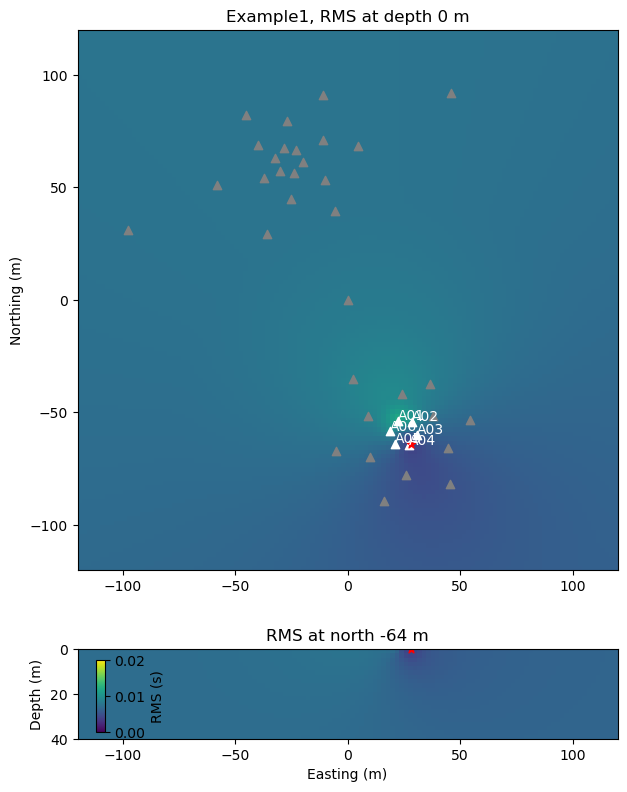

In [7]:
# Plot the RMS distributions
fig, ax1, ax2, ax3 = plot_rms(rmsvol, evdpind, evnoind, eveaind, depgrid, norgrid, easgrid, stadf, pickdf, evname, rmsmax=0.02)

outpath = join(root, timewin, f"RMS_{evname}.png")
#outpath = join(root, timewin, f"RMS_{evname}_BothArray.png")
fig.savefig(outpath, dpi=300)

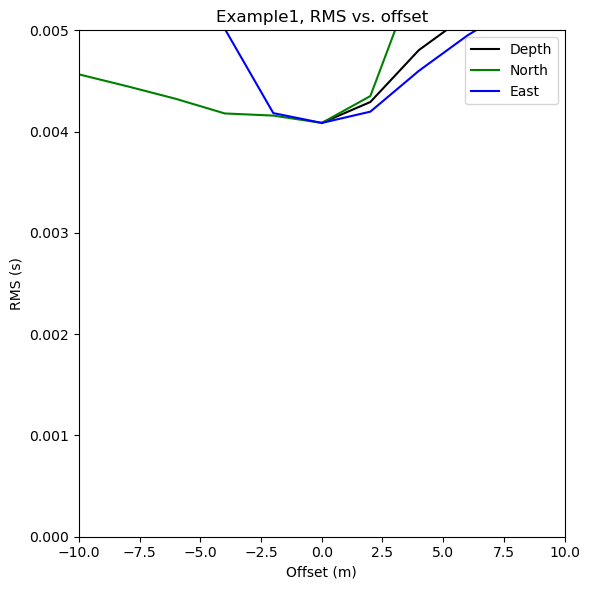

In [8]:
# Plot the RMS as functions of depth, north, and east around the minimum

## Extract the RMS values around the minimum
numpts_win = 10
depgrid_win = depgrid[np.maximum(evdpind-numpts_win//2, 0) : np.minimum(evdpind+numpts_win//2, numdep-1)]-evdp
norgrid_win = norgrid[np.maximum(evnoind-numpts_win//2, 0) : np.minimum(evnoind+numpts_win//2, numnor-1)]-evno
easgrid_win = easgrid[np.maximum(eveaind-numpts_win//2, 0) : np.minimum(eveaind+numpts_win//2, numeas-1)]-evea

## Depth
fig = plt.figure(figsize=(6, 6))
plt.plot(depgrid_win, rmsvol[np.maximum(evdpind-numpts_win//2, 0) : np.minimum(evdpind+numpts_win//2, numdep-1), evnoind, eveaind], 'k', label="Depth")
plt.plot(norgrid_win, rmsvol[evdpind, np.maximum(evnoind-numpts_win//2, 0) : np.minimum(evnoind+numpts_win//2, numnor-1), eveaind], 'g', label="North")
plt.plot(easgrid_win, rmsvol[evdpind, evnoind, np.maximum(eveaind-numpts_win//2, 0) : np.minimum(eveaind+numpts_win//2, numeas-1)], 'b', label="East")
plt.xlim([-10, 10])
plt.ylim([0, 0.005])
plt.xlabel("Offset (m)")
plt.ylabel("RMS (s)")
plt.title(f"{evname}, RMS vs. offset")
plt.legend()

outpath = join(root, timewin, f"RMSoffsets_{evname}.png")
outpath = join(root, timewin, f"RMSoffsets_{evname}_BothArray.png")
fig.tight_layout()
fig.savefig(outpath, dpi=300)

In [9]:
# Save the event hypocenter and origin time
outpath = join(root, timewin, f"EventInfo_{evname}.dat")
with open(outpath, "w") as file:
    file.write(f"{evdp:.0f} {evno:.0f} {evea:.0f} {evori}")